# Discretization
Here we will describe *Invert4Geom* approach to discretization. Discretization refers to the process of transforming something of continuous-value (smoothly varying) into a discrete form. For example, a Digital Elevation Model (DEM) is a discretized representation of the elevation of a landscape. Each grid cell of the DEM has a discrete value.

In *Invert4Geom* we are interested in modeling the geometry (i.e. relief, topography) of some geologic layer. This maybe to the geometry of the Earth's surface (referred to as topography), the geometry of the Moho, or many other examples.

To do this, we must treat these geologic layers as density contrasts, separating materials of differing densities. For example, the Moho is the density contrast between the Earth's crust and mantle, or the Earth's surface, is terrestrial regions, is the density contrast between air and rock. 

To discretize these density contrasts, we use a layer of adjacent, vertical, right-rectangular prisms, each assigned a density contrast value. This notebook walks you though how this discretization is achieved, using a synthetic dataset of topography. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2


import xarray as xr
from polartoolkit import maps

from invert4geom import plotting, synthetic, utils

## Create some topography data

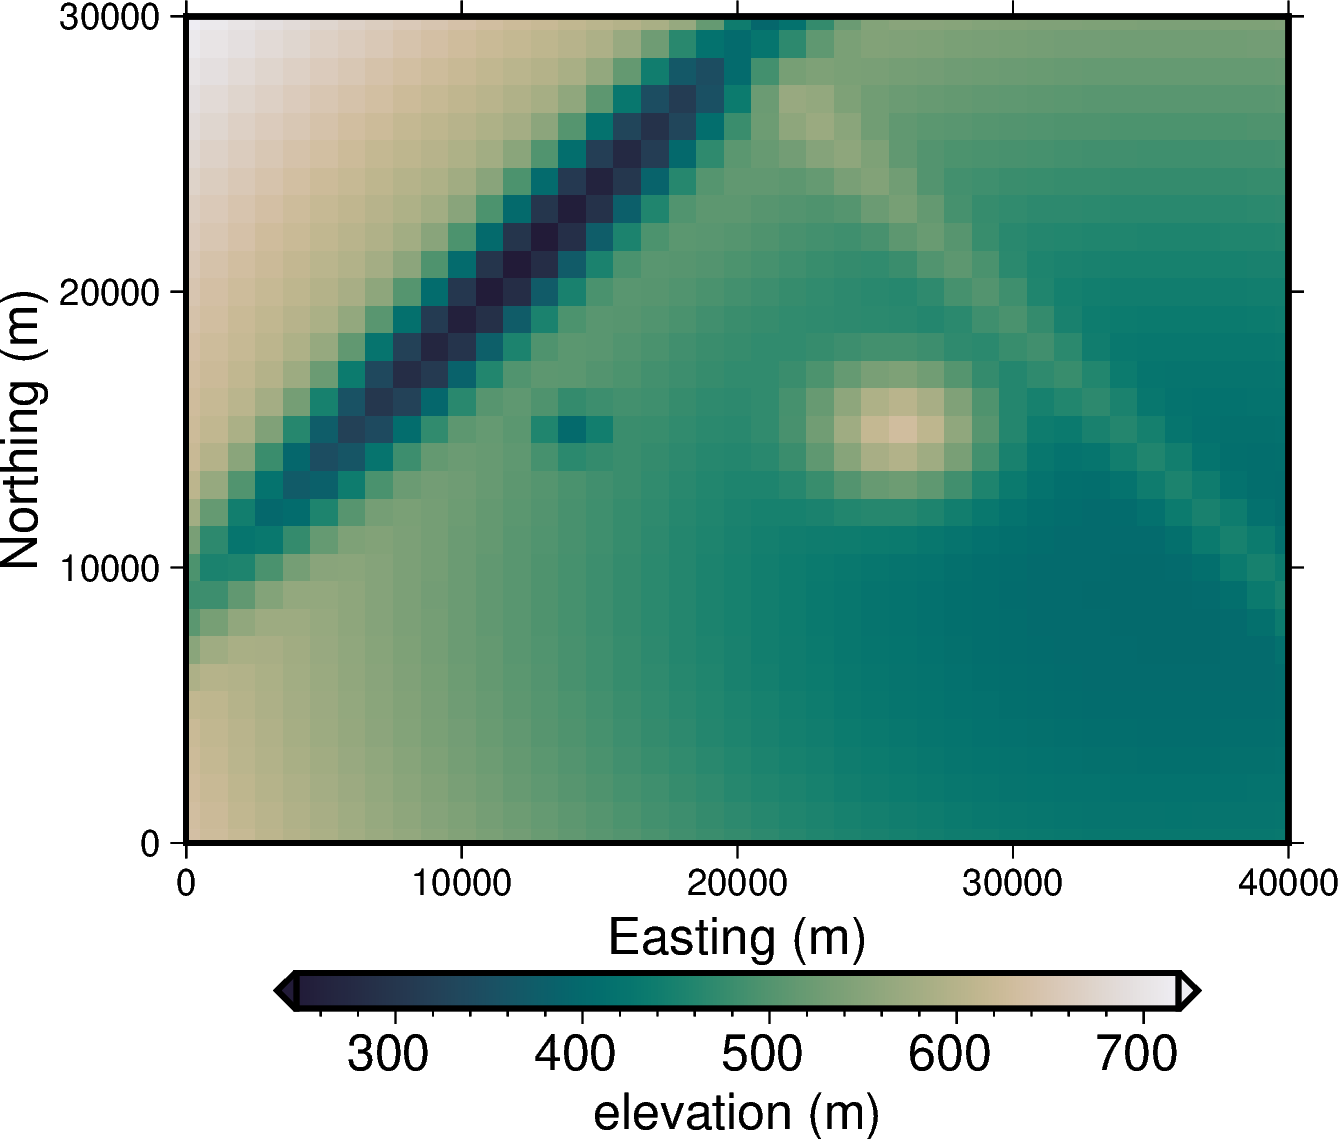

<xarray.DataArray 'upward' (northing: 31, easting: 41)> Size: 10kB
array([[637.12943453, 627.28784729, 617.55840384, ..., 428.39025144,
        429.33158321, 430.64751872],
       [632.95724141, 623.04617819, 613.24496334, ..., 422.67589466,
        423.6241977 , 424.94987872],
       [629.2139621 , 619.27333357, 609.41212904, ..., 417.59868139,
        418.55317844, 419.88752006],
       ...,
       [701.54094486, 692.82534357, 684.20926165, ..., 516.68829114,
        517.52190298, 518.68725132],
       [709.90739328, 701.33808009, 692.86661587, ..., 528.15742206,
        528.97704204, 530.12283044],
       [718.55151946, 710.13334959, 701.81130286, ..., 540.00720706,
        540.8123708 , 541.93795008]])
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_grd(
    topography,
    fig_height=7,
    # title="Topography",
    # title_font="14p",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_yoffset=1.1,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000+lEasting (m)", "yaf10000+lNorthing (m)"],
)
fig.show()

topography

## Discretize the topography as a prism layer

This will convert each topographic grid cell into the a vertical prism. Each of these prisms is define by a top and a bottom. 

A reference level, `zref`, is chosen to be equal to the mean topographic elevation. Each prism is created between the grid cell's elevation and the elevation of `zref`. This means some prisms are above `zref` and other are below.

In this example, our topography represents the surface of the earth, which can be thought of as the density contrast between `air` (~1 kg/m³) and `rock` (~2670 kg/m³). Each prism is assigned this density contrast value (2670 kg/m³ - 1 kg/m³), but prisms above the `zref` are assigned a positive density contrasts (+2669 kg/m³) and prisms below `zref` are assigned a negative density contrast (-2669 kg/m³). 

In [5]:
# the density contrast is between rock (~2670 kg/m³) and air (~1 kg/m³)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    topography,
    zref,
    density=density,
)
prisms

<xarray.Dataset> Size: 41kB
Dimensions:    (northing: 31, easting: 41)
Coordinates:
  * easting    (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing   (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
    top        (northing, easting) float64 10kB 637.1 627.3 ... 540.8 541.9
    bottom     (northing, easting) float64 10kB 492.3 492.3 ... 492.3 492.3
Data variables:
    density    (northing, easting) int64 10kB 2669 2669 2669 ... 2669 2669 2669
    thickness  (northing, easting) float64 10kB 144.9 135.0 ... 48.54 49.67
Attributes:
    coords_units:      meters
    properties_units:  SI

### The below figure colors each prism by the value of its thickness.

Notice that purple prisms show where the original topographic elevation was close the the `zref` value.

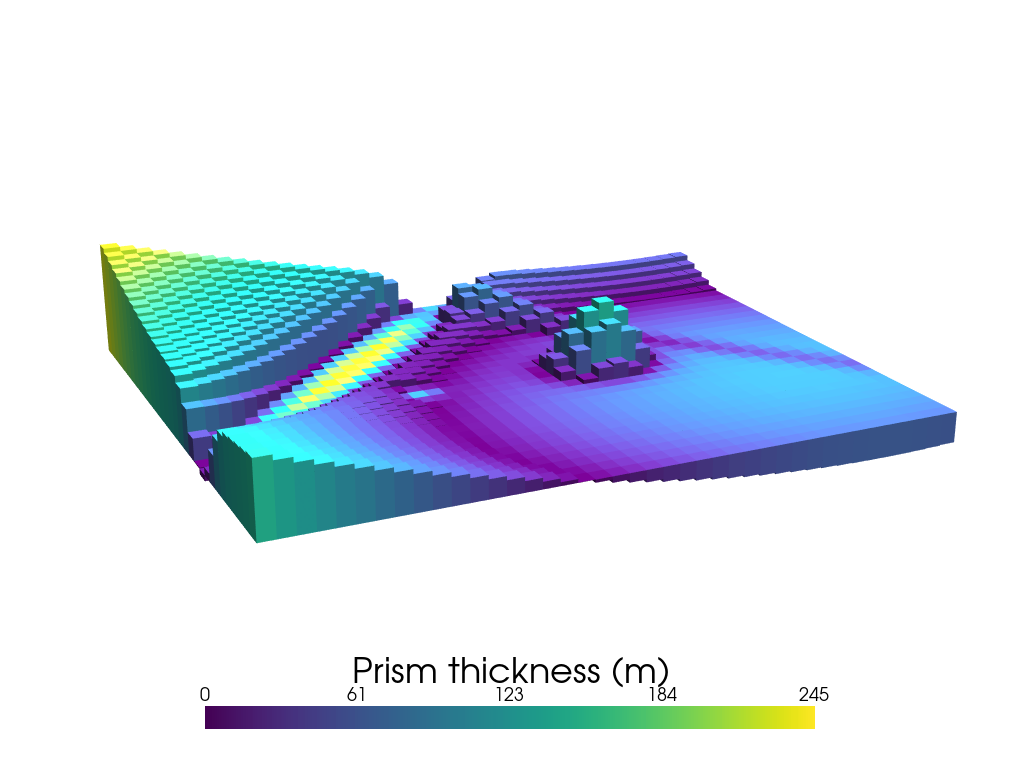

In [4]:
plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Prism thickness (m)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

### The below figure instead colors each prism by its assigned density contrast value.

Notice that there are only two density contrast options, positive (yellow) and negative (purple).

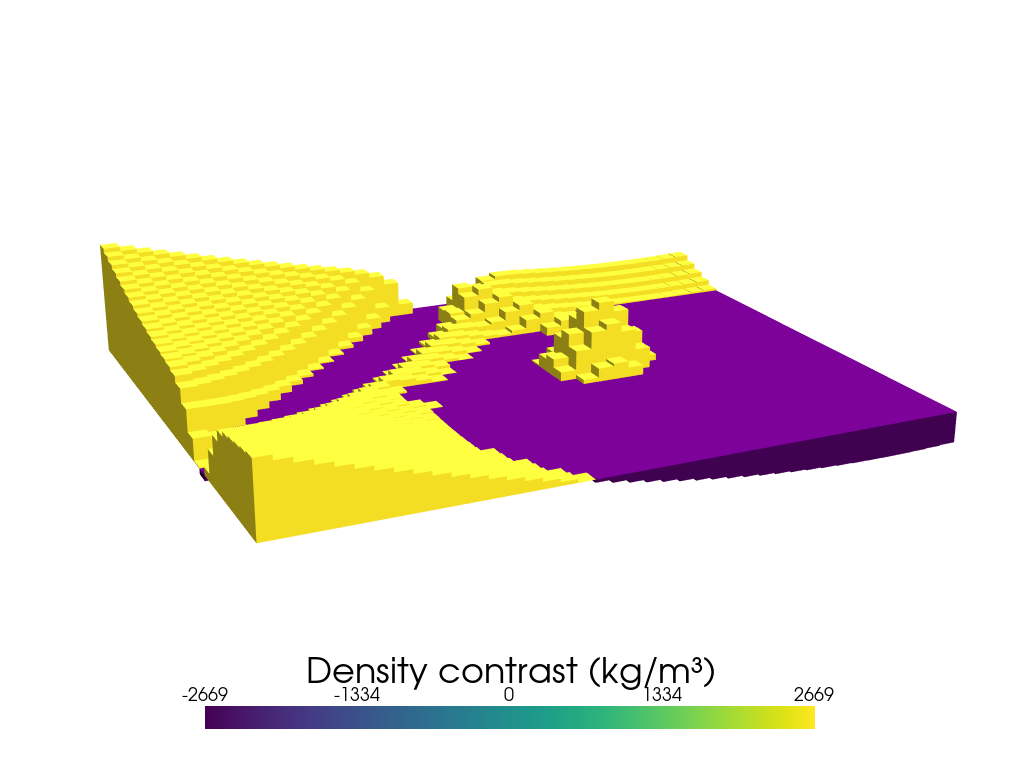

In [5]:
plotting.show_prism_layers(
    prisms,
    color_by="density",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Density contrast (kg/m³)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

### Changing zref

Below we show what a zref outside the range of the topography data does.

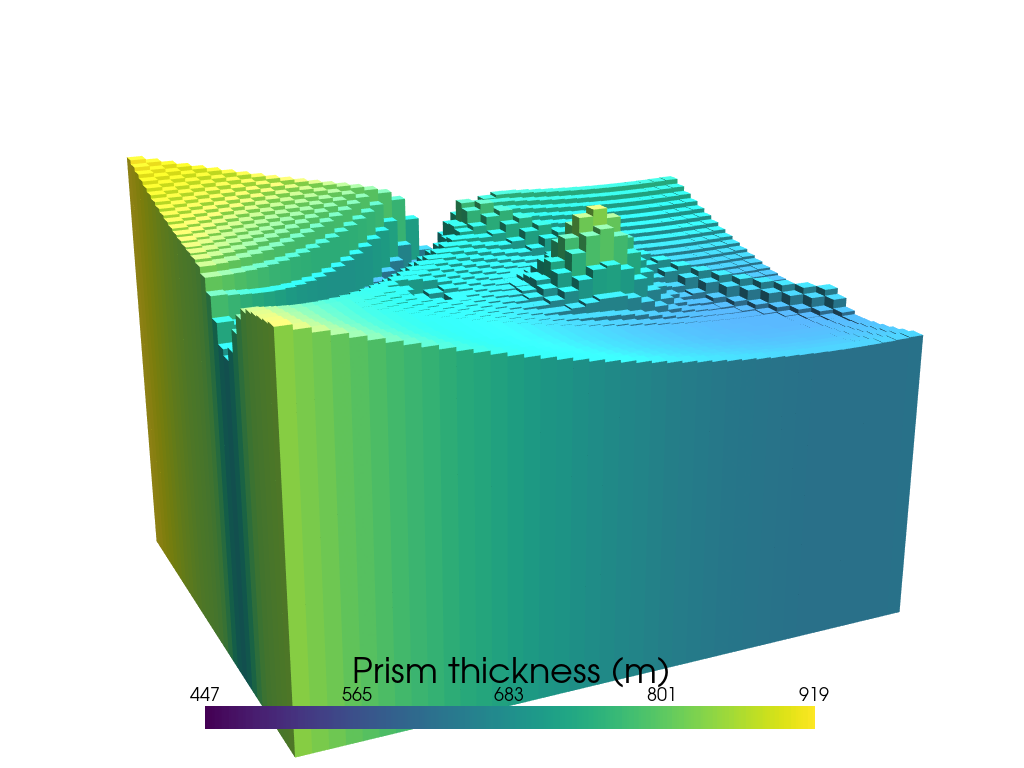

In [7]:
zref = -200

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    topography,
    zref,
    density=density,
)
prisms
plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Prism thickness (m)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)